# 目標
- 最急勾配法により力学系の平衡点を探す。
- 分岐パラメータの変化に追随して平衡点を探し、分岐点を見つける。

# 準備
Lorenz系の導入など

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import time
#% matplotlib inline
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

from scipy.integrate import solve_ivp

class Lorenz(object):
    def __init__(self, sigma=10., beta=8 / 3., rho=28., **kwargs):
        super().__init__(**kwargs)

        self.sigma = sigma
        self.beta = beta
        self.rho = rho

    def __call__(self, t, x):
        """ x here is [x, y, z] """
        # x = tf.cast(x, tf.float64)

        dx_dt = self.sigma * (x[1] - x[0])
        dy_dt = x[0] * (self.rho - x[2]) - x[1]
        dz_dt = x[0] * x[1] - self.beta * x[2]

        dX_dt = tf.stack([dx_dt, dy_dt, dz_dt])
        return dX_dt

Jacobian定義

In [2]:
def jacobian(t, f, x):
    """ return jacobian matrix of f at x"""
    n = x.shape[-1].value
    fx = f(t, x)
    if x.shape[-1].value != fx.shape[-1].value:
        print('For calculating Jacobian matrix',
              'dimensions of f(x) and x must be the same')
        return

    return tf.concat([tf.gradients(fx[i], x) for i in range(0, n)], 0)

# 各変数、パラメータ、関数の定義

In [3]:
rho = tf.Variable(28.0, dtype=tf.float64,
                             name='rho')
sigma = tf.Variable(10.0, dtype=tf.float64,
                     name='sigma')
beta = tf.Variable(8.0/3.0, dtype=tf.float64,
                                    name='sigma')

f_lorenz = Lorenz(sigma=sigma, rho=rho, beta=beta)

# define a state variable x as Variable
x = tf.Variable([1,1,10], dtype=tf.float64, name='x') 
fx= f_lorenz(None,x)

# op for initialize x from outside of TF
x_init=  tf.placeholder(dtype=tf.float64, shape=(3), name='x_init')
init_x_op = tf.assign(x,x_init)

Instructions for updating:
Colocations handled automatically by placer.


# 損失関数 ||f||^2 とoptimizer

In [4]:

# squarenorm of f(x): sum_i{f_i(x)^2}
loss = tf.math.reduce_sum( tf.math.square(fx))

# optimizer

opt = tf.train.GradientDescentOptimizer(1e-3)
train_op = opt.minimize(loss, var_list=[x])


## 動作確認

In [5]:
sess =  tf.Session()
sess.run(tf.initializers.global_variables())

sess.run(init_x_op, feed_dict={x_init:[5,5,5]})
print("x:",sess.run(x))
print("loss:",sess.run(loss))

# update x by train op
print("update x by train op")
sess.run(train_op)
print("x:",sess.run(x))
print("loss:",sess.run(loss))

x: [5. 5. 5.]
loss: 12236.111111111111
update x by train op
x: [-0.17666691  5.10333334  6.16222228]
loss: 3168.619885118489


# 最急降下法を行う関数

In [6]:
def find_equilibrium(sess,loss,x0,step_max=10000,eps=1e-12,printinfo=True):
    # set initial candidate x
    sess.run(init_x_op, feed_dict={x_init:x0})
    print('initial state')
    print("x:", sess.run(x))
    step = 0
    np.set_printoptions(precision=5)

    lo =sess.run(loss)
    while(lo > eps and step < step_max):
        step += 1
        _, xval, lo = sess.run((train_op, x, loss))
        if printinfo and step % 100 == 0:
          print("step:{:d} x:{:} sqnorm(f):{:.5g}".format(step, xval, lo))
    print('final result')
    print("step:{:d} x:{:} sqnorm(f):{:.5g}".format(step,xval,lo))
    sucsess = lo < eps
    return xval, lo, sucsess

異なる初期値から探索を始め、３つの平衡点を見つける。

In [7]:
x_eq1, sqnorm1, suc = find_equilibrium(sess,loss,[3,5,21])

x_eq2, sqnorm2, suc = find_equilibrium(sess,loss,[-4,-3,20])

x_eq0, sqnorm0, suc = find_equilibrium(sess,loss,[2,2,5])

initial state
x: [ 3.  5. 21.]
step:100 x:[ 8.48524  8.48525 26.99987] sqnorm(f):1.6352e-06
final result
step:152 x:[ 8.48528  8.48528 27.     ] sqnorm(f):8.2207e-13
initial state
x: [-4. -3. 20.]
step:100 x:[-8.48506 -8.48514 26.99937] sqnorm(f):3.9507e-05
final result
step:163 x:[-8.48528 -8.48528 27.     ] sqnorm(f):9.2404e-13
initial state
x: [2. 2. 5.]
step:100 x:[4.41482e-08 2.50015e-07 1.25376e+00] sqnorm(f):11.503
step:200 x:[1.30271e-15 7.98015e-15 2.99308e-01] sqnorm(f):0.65556
step:300 x:[3.19214e-23 1.99199e-22 7.14530e-02] sqnorm(f):0.037361
step:400 x:[7.49796e-31 4.69961e-30 1.70578e-02] sqnorm(f):0.0021292
step:500 x:[1.74368e-38 1.09406e-37 4.07216e-03] sqnorm(f):0.00012135
step:600 x:[4.04538e-46 2.53889e-45 9.72136e-04] sqnorm(f):6.9157e-06
step:700 x:[9.38003e-54 5.88728e-53 2.32076e-04] sqnorm(f):3.9413e-07
step:800 x:[2.17466e-61 1.36492e-60 5.54028e-05] sqnorm(f):2.2462e-08
step:900 x:[5.04154e-69 3.16432e-68 1.32262e-05] sqnorm(f):1.2801e-09
step:1000 x:[1.16878

# パラメータの変化に伴う平衡点の変化の追跡と分岐点の探索

## 探索アルゴリズムをクラスにして変数を隠蔽化しておく。

In [8]:
class Find_equilibrium:
    def __init__(self, f, eps=1e-12, infolevel=2):
        self.eps = eps # precision
        self.infolevel = infolevel
        self.x = tf.Variable([1,1,10], dtype=tf.float64, name='x') # candidate of equilibrium
        self.fx= f(None,self.x)
        # squarenorm of f(x): sum_i{f_i(x)^2}
        self.loss = tf.math.reduce_sum( tf.math.square(self.fx))

        # op for initialize x from outside of TF
        self.x_init=  tf.placeholder(dtype=tf.float64, shape=(3), name='x_init')
        self.init_x_op = tf.assign(self.x,self.x_init)

        # optimizer

        opt = tf.train.GradientDescentOptimizer(1e-3)
        self.train_op = opt.minimize(self.loss, var_list=[self.x])

    def find(self, sess, x0, step_max=10000):
        sess.run(self.init_x_op, feed_dict={self.x_init: x0})
        if self.infolevel >= 1:
            print('initial state')
            print("x:", sess.run(self.x))
        step = 0
        np.set_printoptions(precision=5)

        lo =sess.run(self.loss)
        # gradient descent search
        while(lo > self.eps and step < step_max):
            step += 1
            _, xval, lo = sess.run((self.train_op, self.x, self.loss))
            if self.infolevel>=2 and step % 10 == 0:
                print("step:{:d} x:{:} sqnorm(f):{:.5g}".format(step, xval, lo))
        # show final results
        if self.infolevel >= 1:
            print('final result')
            print("step:{:d} x:{:} sqnorm(f):{:.5g}".format(step,xval,lo))

        # record results to member variable
        self.sucsess = lo < self.eps
        self.xeq = xval
        self.sqnorm = lo
        self.step = step
        return xval


クラス版の動作のチェック

In [9]:
feq = Find_equilibrium(f_lorenz, eps=1e-12, infolevel=2)

feq.find(sess, np.array([5, 5, 20.0], dtype=np.float64), step_max=10000)

initial state
x: [ 5.  5. 20.]
step:10 x:[ 5.42217  6.43195 21.5525 ] sqnorm(f):1484.6
step:20 x:[ 6.77094  7.41857 23.695  ] sqnorm(f):760.48
step:30 x:[ 7.87191  8.11421 25.64057] sqnorm(f):165.99
step:40 x:[ 8.32552  8.38602 26.59135] sqnorm(f):16.445
step:50 x:[ 8.44647  8.46056 26.89276] sqnorm(f):1.1544
step:60 x:[ 8.47577  8.47917 26.97301] sqnorm(f):0.073405
step:70 x:[ 8.48293  8.48377 26.99328] sqnorm(f):0.004551
step:80 x:[ 8.4847   8.48491 26.99833] sqnorm(f):0.00028037
step:90 x:[ 8.48514  8.48519 26.99959] sqnorm(f):1.7245e-05
step:100 x:[ 8.48525  8.48526 26.9999 ] sqnorm(f):1.0603e-06
step:110 x:[ 8.48527  8.48528 26.99997] sqnorm(f):6.5188e-08
step:120 x:[ 8.48528  8.48528 26.99999] sqnorm(f):4.0076e-09
step:130 x:[ 8.48528  8.48528 27.     ] sqnorm(f):2.4638e-10
step:140 x:[ 8.48528  8.48528 27.     ] sqnorm(f):1.5147e-11
step:150 x:[ 8.48528  8.48528 27.     ] sqnorm(f):9.3118e-13
final result
step:150 x:[ 8.48528  8.48528 27.     ] sqnorm(f):9.3118e-13


array([ 8.48528,  8.48528, 27.     ])

## 分岐パラメータ探索
グラフの作成

In [10]:
tf.reset_default_graph()

rho = tf.Variable(28.0, dtype=tf.float64,
                             name='rho')
sigma = tf.Variable(10.0, dtype=tf.float64,
                     name='sigma')
beta = tf.Variable(8.0/3.0, dtype=tf.float64,
                                    name='sigma')

# rho を変えるop
rho_as = tf.placeholder(shape=(),dtype=tf.float64)
assign_rho_op = tf.assign(rho,rho_as)


f_lorenz = Lorenz(sigma=sigma, rho=rho, beta=beta)

feq = Find_equilibrium(f_lorenz, eps=1e-12, infolevel=0) #詳細なログをみる場合infologを変える．

Df = jacobian(None,f_lorenz,feq.x)

初期値、範囲など設定

In [11]:
#initial guess
x0 = np.array([3.0,3.0,10])
# range of bifurcation parameter rho
rho_max = 30
rho_min = 2.0
rho_step = 0.5
rs = np.arange(rho_min, rho_max+rho_step,rho_step)

パラメータを変えながら平衡点を探索
見つかったらヤコビアンの固有値を計算

In [12]:
sess=tf.Session()
sess.run(tf.initializers.global_variables())

xeqs=[]
eigvals = []

for r in rs:
    sess.run(assign_rho_op, feed_dict={rho_as:r})  # assign rho value
    xeq = feq.find(sess,x0,step_max=10000)
    xeqs.append(xeq)

    # jacobian and eigenvalues of equiribrium
    df = sess.run(Df)
    eigval, eigvecs = np.linalg.eig(df)
    eigvals.append(eigval)
    x0 = xeq # set next starting point

## 結果の図示

# アトラクタの描画
軌道の計算用の関数

In [14]:
def solve_lorenz(sess,fx,x0,ts):
    """ numerically solve lorenz equation
        using tensorflow operation fx
    """
    f_lorenz_tf = lambda t,xt: sess.run(fx, feed_dict={x_pf: xt})


    start_time = time.time()
    sol_lorenz = solve_ivp(fun=f_lorenz_tf,
                       t_span=[tstart, tend], y0=x0, t_eval=ts)
    integral_time_tf = time.time() - start_time
    print("processing time (TF): %.5f" % integral_time_tf)


    t_lo = sol_lorenz['t']
    x_lo = sol_lorenz['y']
    return x_lo,t_lo

軌道の計算

In [15]:
x0 = np.array([5, 8, 15], dtype=np.float64)   # initial value

# integrating time
dt = 0.01
tstart = 0.0
tend = 80.0
ts = np.arange(tstart, tend+dt, dt)

x_pf = tf.placeholder(dtype=tf.float64, shape=(3), name='x_pf')
fx_pf = f_lorenz(None, x_pf)  # r.h.s. of ODE

sess.close()
sess = tf.Session()
sess.run(tf.initializers.global_variables())
# set rho to default value 28
sess.run(assign_rho_op, feed_dict={rho_as:28.0})  # assign rho value

x_lo, t_lo = solve_lorenz(sess, fx_pf, x0, ts)

processing time (TF): 1.96022


図

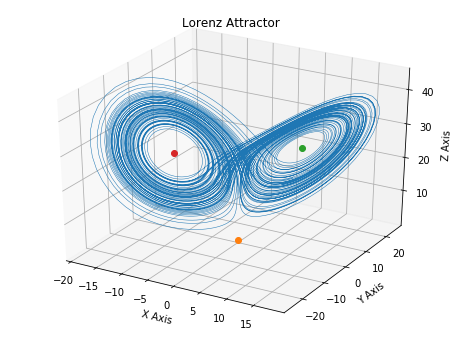

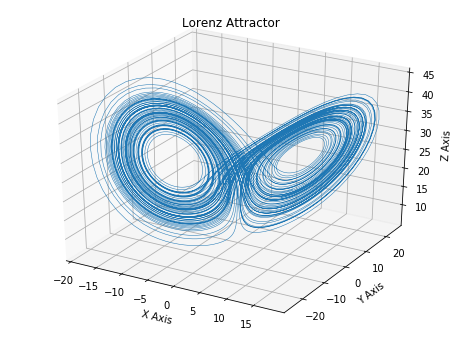

In [16]:

# 3d
fig2 = plt.figure(figsize=(8,6))
ax2 = fig2.add_subplot(111,projection='3d')
ax2.plot(x_lo[0], x_lo[1], x_lo[2], '-', lw=0.5)
ax2.plot([x_eq0[0]], [x_eq0[1]], [x_eq0[2]], 'o')
ax2.plot([x_eq1[0]], [x_eq1[1]], [x_eq1[2]], 'o')
ax2.plot([x_eq2[0]], [x_eq2[1]], [x_eq2[2]], 'o')
ax2.set_xlabel("X Axis")
ax2.set_ylabel("Y Axis")
ax2.set_zlabel("Z Axis")
ax2.set_title("Lorenz Attractor")
plt.pause(0.01)

fig3 = plt.figure(figsize=(8,6))
ax = fig3.add_subplot(111,projection='3d')
ax.plot(x_lo[0], x_lo[1], x_lo[2], '-', lw=0.5)
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
ax.set_title("Lorenz Attractor")
plt.pause(0.01)